In [2]:
import scipy.io
import scipy.stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from os import chdir
chdir('data/Cp_16_05_01')

## experience 1

### Bases de données GPS et vitesse

In [4]:
#Telechargement des données pour l'experience 1 (qui sont sous forme de dictionnaire)
exp_ind = 1
gps1 = scipy.io.loadmat('juan{}_gps.mat'.format(exp_ind))
sensors1 = scipy.io.loadmat('juan{}_etc.mat'.format(exp_ind))

In [5]:
#Mise en forme en Data Frame
gps_df = pd.DataFrame(gps1['GPS'], columns=gps1['GPSFieldsOrder'])
sensors_df = pd.DataFrame(sensors1['SENSORS'], columns=sensors1['ETCFieldsOrder'])

In [6]:
#Changement du nom des variables
gps_df = pd.DataFrame(gps1['GPS'], columns = ['time', 'ts', 'lat', 'long', 'alti', 'course', 'speedOG', 'speedV', 
                                              'SgmLat', 'SgmLong', 'SgmAlti', 'mode', 'sats'])
sensors_df = pd.DataFrame(sensors1['SENSORS'], columns = ['time', 'counts', 'accel', 'steer', 'brake', 'speed'])

In [10]:
#Bien mettre en forme les données 

def readSensorData(sensors_df):
    '''Velocity and steering'''
    # Sensor params
    KV1 = 0.024970 * (1 - 0.21)
    KA1 = 0.00040 * (1 + 0)
    KA0 = 2022
    Kx1 = 1.0127
    Kx2 = 0.0042
    
    time_sensors = sensors_df['time'].values / 1000.
    steering = Kx1 * (sensors_df['steer'].values - KA0) * KA1 + Kx2 
    velocity = KV1 * sensors_df['speed'].values
    
    return time_sensors, steering, velocity


def readGPSData(gps_df):
    '''Latitude and longtitude'''
    # Reference point
    LAT0  = -33.8884
    LONG0 = 151.1948
    
    # Params (wtf is this sorcery)
    a =  6378137.0
    b  = a * (1 - 0.003352810664747)
    kpi = np.pi / 180
    cf = np.cos(LAT0 * kpi)
    sf = np.abs(np.sin(LAT0 * kpi))
    Ro = a ** 2 * cf / np.abs(np.sqrt((a *cf) ** 2 + (b * sf) ** 2))  ;
    RR = b / a  * np.abs(np.sqrt(a ** 2- Ro ** 2)) / sf ;
    
    time_gps = gps_df['time'].values / 1000.
    latitude = - RR * kpi * (gps_df['lat'].values + LAT0)
    longtitude = Ro * kpi * (gps_df['long'].values - LONG0)
    
    return time_gps, latitude, longtitude

In [11]:
def scanData():
    '''
    Pour avoir le temps, le sensor et l'indice de chaque mesure qui arrive
    Au temps time[i] on a une mesure de sensor[i]
    (1 si gps, 2 si steering et velocity)
    dans l'indice index[i] du tableau correspondant
    '''
    time_sensors, steering, velocity = readSensorData(sensors_df)
    time_gps, latitude, longtitude = readGPSData(gps_df)
    
    times = [(1, i, time) for i, time in enumerate(time_gps)]
    times.extend([(2, i, time) for i, time in enumerate(time_sensors)])

    times = np.array(sorted(times, key=lambda u: u[2]))
    time, sensor, index = times[:, 2], times[:, 0], times[:, 1].astype(int)
    return time, sensor, index

In [12]:
#Construction des bases de données finales 
GPSData = pd.DataFrame(readGPSData(gps_df), ['times_GPS', 'latitude', 'longitude']).T
SensorData = pd.DataFrame(readSensorData(sensors_df), ['time_sensors', 'steering', 'velocity']).T

In [13]:
GPSData.head()

,times_GPS,latitude,longitude
0,851.227,-5.707890,6.615680
1,851.428,-5.709734,6.615680
2,851.628,-5.702355,6.614138
3,851.828,-5.700510,6.615680
4,852.028,-5.702355,6.615680


In [14]:
SensorData.head()

,time_sensors,steering,velocity
0,851.292,0.064557,0.0
1,851.317,0.064962,0.0
2,851.342,0.064557,0.0
3,851.367,0.064557,0.0
4,851.392,0.064557,0.0


## Petites visualisations

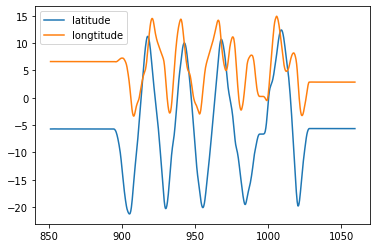

In [15]:
time_gps, latitude, longtitude = readGPSData(gps_df)
plt.plot(time_gps, latitude, label='latitude')
plt.plot(time_gps, longtitude, label='longtitude')
plt.legend()

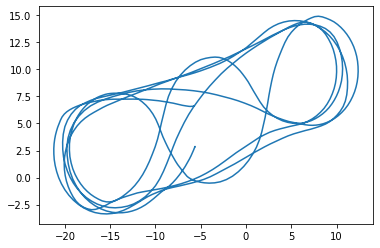

In [16]:
plt.plot(latitude, longtitude)

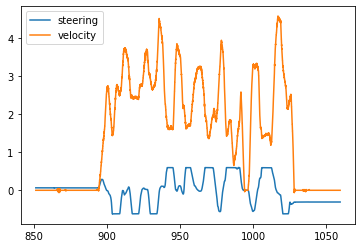

In [17]:
time_sensors, steering, velocity = readSensorData(sensors_df)
plt.plot(time_sensors, steering, label='steering')
plt.plot(time_sensors, velocity, label='velocity')
plt.legend()

In [18]:
def initilisation_pf(N): #on initialise avec des uniformes sur les espaces de vie des variables
    
    init_state = {
        'x': np.random.uniform(low=-20, high=10, size=N),
        'y': np.random.uniform(low=-2.5, high=15, size=N),
        'v': np.random.uniform(low=0, high=4, size=N),
        'psi': np.random.uniform(low=0, high=2*np.pi, size=N),
        'beta': np.random.uniform(low=-0.6, high=0.6, size=N),
        'beta_dot': np.random.uniform(low=-0.6, high=0.6, size=N)
    }
    init_poids = np.ones(N) / N
    
    return init_state, init_poids   

In [19]:
# Geometric constants
L = 2.83
H = 0.76
a = 3.78
b = 0.5

def transition_model(current_state, dt):
    '''return the state transition model without taking into
    account he state noise (v' and beta'')'''
    # Retrieve initial states
    x = current_state['x']
    y = current_state['y']
    v = current_state['v']

    psi = current_state['psi']
    beta = current_state['beta']
    beta_dot = current_state['beta_dot']
    
    # Next states
    next_state = dict()
    next_state['x'] = x + dt * v * (np.cos(psi) + (- a * np.sin(psi) + b * np.cos(psi)) * np.tan(beta) / L)
    next_state['y'] = y + dt * v * (np.sin(psi) + (a * np.cos(psi) + b * np.sin(psi)) * np.tan(beta) / L)
    next_state['v'] = v
    
    next_state['psi'] = psi + dt * v * np.tan(beta) / L
    next_state['beta'] = beta + dt * beta_dot
    next_state['beta_dot'] = beta_dot
    
    return next_state   

In [20]:
var_gps = 0.002
var_sensors = {'beta': 0.002, 'v': 0.1}

def update_model(N, weights, update_GPS, measures, particles):    
    #Cas GPS
    if update_GPS:
        erreur_mesure = np.linalg.norm([particles['x'] - measures['x'], 
                                        particles['y'] - measures['y']], axis=0)
        for i in range(N): #mise à jour des poids
            weights[i] *= scipy.stats.norm(0, var_gps).pdf(erreur_mesure[i])

    #Cas sensors   
    else:
        erreur_mesure_beta = ((particles['beta'] - measures['beta']) + np.pi) % (2 * np.pi) - np.pi
        erreur_mesure_v = particles['v'] - measures['v']                                  
        for i in range(N): #mise à jour des poids
            weights[i] *= (
                scipy.stats.norm(0, var_sensors['v']).pdf(erreur_mesure_v[i])
                * scipy.stats.norm(0, var_sensors['beta']).pdf(erreur_mesure_beta[i])
            )
    
    weights += 1e-300 # Eviter les divisions par 0
    weights /= sum(weights) # normalize  
        
    return weights
        


In [21]:
def simple_resample(N, particles, weights):
    cumulative_sum = np.cumsum(weights)
    cumulative_sum[-1] = 1. # avoid round-off error
    indexes = np.searchsorted(cumulative_sum, np.random.uniform(0, 1, size=N))
    # resample according to indexes
    particles = {key: particles[key][indexes] for key in particles}
    weights.fill(1.0 / N)
    return particles, weights
    

In [22]:
def predictions(weights, particles): #Renvoi la prédiction de l'état à chaque temps
    tab_predict = [sum(particles['x'] * weights), sum(particles['y'] * weights), sum(particles['v'] * weights), 
     sum(particles['beta'] * weights)]
    
    return tab_predict

In [23]:
#Définissons maintenant le corps de l'algo avec les différentes fonctions crées

list_predict=list()

time_sensors, steering, velocity = readSensorData(sensors_df)
time_gps, latitude, longtitude = readGPSData(gps_df)
time, sensor, index = scanData()

def particle_filter(N, skip=1):
    #Initialisation de l'algo
    particles, weights = initilisation_pf(N)
    t_previous = time[0]
    
    for i in range(len(time)):
        if i % skip == 0:
            t = time[i] 
            particles = transition_model(particles, dt=t-t_previous)

            update_GPS = sensor[i] == 1
            if update_GPS:
                measures = {'x': latitude[index[i]], 'y': longtitude[index[i]]}
            else:
                measures = {'beta': steering[index[i]], 'v': velocity[index[i]]}

            weights = update_model(N, weights, update_GPS, measures, particles)
            
            # Resampling
            n_eff = 1 / np.sum(weights ** 2)
            if n_eff <= .8 * N:
                particles, weights = simple_resample(N, particles, weights)
            
            t_previous = t
            list_predict.append(predictions(weights, particles))
            
    return list_predict

In [1]:
list_predict = particle_filter(N=300, skip=10)

In [43]:
len(list_predict)

1220

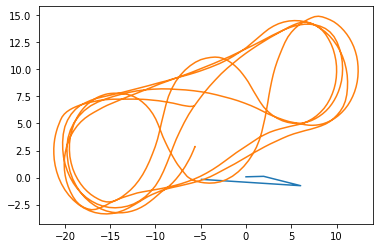

In [44]:
plt.plot(list_predict[:][0], list_predict[:][1])
plt.plot(latitude, longtitude)

# Algorithme 5

Création d'un vecteur temps "à ma façon" :

In [ ]:
S1_time = gps_df['time'].values
S2_time = sensors_df['time'].values
S3_time = laser_df['time'].values

In [ ]:
nb_2_3 = 0
times_2_3 = []

for a in S2_time:
    for b in S3_time:
        if (a == b):
            nb_2_3 += 1
            times_2_3.append(a)
            
print(nb_2_3)

In [ ]:
v_temps = np.ones((len(S1_time) + nb_2_3, 2))
v_temps[0:len(S1_time), 0] = S1_time
v_temps[1040:, 0] = times_2_3
v_temps[1040:, 1] = 23
print(v_temps[1038:1042, :])
v_temps = v_temps[np.argsort(v_temps[:, 0])]

Petites sous-fonctions de l'algo final à compléter :

In [ ]:
def q_alpha1 (alpha1, c1_new, sigma1) :
    '''
    === ÉQUATION 26 page 11 ===
    Ici, alpha1 est dans {0, 1}. Par l'article, la loi de Dirichlet est réduite
    à une loi beta.
    Pas de a1 = alpha_{1, t} ? 
    '''
    
    a_prime = np.empty(2)
    a_prime[0] = (sigma1 / (1 + sigma1)) * alpha1[0] + (c1_new == 0) / (1 + sigma1)
    a_prime[1] = (sigma1 / (1 + sigma1)) * alpha1[1] + (c1_new == 1) / (1 + sigma1)
    
    return np.random.dirichlet((1 + sigma1) * a_prime)

In [ ]:
def q_c1 (c1, xchap, SIGMA, alpha1, z1) :
    '''
    === ÉQUATION 29 page 11 ===
    À définir : p0_z1, h et S
    '''
    h = 
    S = 
    return (1 - alpha1[1]) * p0_z1(z1) * (c1 == 0) + alpha1[1] * (S * np.random.randn(1) + h) * (c1 == 1) 
    # S = variance; h = moyenne

In [ ]:
def q_sigma1 (s1, sigma1_new, sigma1, alpha1_new, alpha1) :
    '''
    === ÉQUATION 28 page 11 ===
    La formule est donnée avec un log.
    Pas de s1 = sigma_{1, t}^alpha ? 
    '''
    lambda_a = 1 * np.random.randn(1) # définir la variance de lambda^alpha, c'est un bruit blanc gaussien
    numerateur = np.random.dirichlet(sigma1_new * alpha1) * (lambda_a * np.random.randn(1) + np.log(sigma1))
    denominateur = np.random.dirichlet(sigma1 * alpha1)
    return numerateur / denominateur

In [ ]:
def calcul_wt (z1, list_c1) :

In [ ]:
def p_z2 () :

In [ ]:
def p_z3 () :

Algorithme :

In [ ]:
def RaoBlackwell_UKF (n_particules, v_temps, eta = 0.8*n_particules):
    
    ### === Initialisation === ###
    
    xhap0 = p_xhap0(x0)
    SIGMA0 = p_SIGMA0(SIG0)
    sigma0 = p_sigma0(sig0)
    alpha0 = p_alpha0(a0, sigma0) # c'est bien sigma0 en deuxième paramètre ?
    w0 = (1./n_particules)*np.ones(n_particules)
    
    ### === Iterations === ###
    
    for t in range (len(time)):
        
        # Mesures z_2,t et z_3,t #
        if (v_temps[t, 1] == 23): 
            
            xchap, SIGMA = UFK(xhap, SIGMA, z2, z3) # en cours (Étienne)
            
            # Update des variables liées au GPS : (à modifier)
            Xt = Xt + T * (Vt*np.cos(psi) + (- a*np.sin(psi) + b*np.cos(psi)) * (Vt/L) * np.tan(beta))
            Yt = Yt + T * (Vt*np.sin(psi) + (a*np.cos(psi) + b*np.sin(psi)) * (Vt/L) * np.tan(beta))
            
            ''' 
            |-----> on ne change rien :
            c1_new = c1
            alpha1_new = alpha1
            sigma1_new = sigma1
            '''
            
            # Update des poids :
            wt = wt * p_z2() * p_z3() # à coder
            
        # Mesures z_1,t #
        if (v_temps[t, 1] == 1) : 
            
            c1_new = q_c1(c1, xchap, SIGMA, alpha1, z1) # à compléter
            alpha1_new = q_alpha1(alpha1, c1_new, sigma1) # fonctionne correctement
            sigma1_new = q_sigma1(s1, sigma1, alpha1_new, alpha1) # à compléter
            xchap, SIGMA = UFK(xhap, SIGMA, c1_new, z1) # en cours (Étienne)
            
            # Update des poids :
            wt = calcul_wt(z1, list_c1) # à coder
            
        # Resampling #
        Neff = 1./sum(wt**2)
        if (Neff <= eta) :
            
            

# A faire (pour avoir l'algo pf et l'algo rao-blackwell):
1 - Sampler le state vector $\tilde{x}_t^{(i)}$ (prendre en compte le state noise), le sensor state variable $\tilde{c}_t^{(i)}$ et les autres pour les particules

2 - Utiliser $\tilde{c}_t^{(i)}$  pour la modelisation du gps

3 - Bien choisir l'importance probability $q$ pour l'algo standard

3 - Trouver la proba cheloue de l'algo Rao-blackwell $p(z_{k,t}|\textbf{z}_{1:t-1})$

4 - Implementer (ou trouver une implementation) de l'UKF

5 - Revoir les distributions initiales $p_0$ (en regardant les histogrammes des mesures par ex)

